In [1]:
import os
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

In [6]:
dtypes = {
    'MachineIdentifier': 'category',
    'AVProductsInstalled': 'float32',
    'CountryIdentifier': 'float32',
    'OrganizationIdentifier': 'float32',
    'GeoNameIdentifier': 'float32',
    'LocaleEnglishNameIdentifier': 'float32',
    'OsBuild': 'int16',
    'OsSuite': 'float32',
    'OsPlatformSubRelease': 'float32',
    'SkuEdition': 'float32',
    'IeVerIdentifier': 'float32',
    'SmartScreen': 'float32',
    'Census_MDC2FormFactor': 'float32',
    'Census_ProcessorCoreCount': 'float32',
    'Census_ProcessorManufacturerIdentifier': 'float32',
    'Census_PrimaryDiskTotalCapacity': 'float32',
    'Census_PrimaryDiskTypeName': 'float32',
    'Census_SystemVolumeTotalCapacity': 'float32',
    'Census_TotalPhysicalRAM': 'float32',
    'Census_ChassisTypeName': 'float32',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches': 'float32',
    'Census_InternalPrimaryDisplayResolutionHorizontal': 'float32',
    'Census_InternalPrimaryDisplayResolutionVertical': 'float32',
    'Census_PowerPlatformRoleName': 'float32',
    'Census_InternalBatteryType': 'float32',
    'Census_InternalBatteryNumberOfCharges': 'float32',
    'Census_OSBranch': 'float32',
    'Census_OSBuildNumber': 'int16',
    'Census_OSBuildRevision': 'int32',
    'Census_OSEdition': 'float32',
    'Census_OSSkuName': 'float32',
    'Census_OSInstallTypeName': 'float32',
    'Census_OSInstallLanguageIdentifier': 'float32',
    'Census_OSUILocaleIdentifier': 'float32',
    'Census_OSWUAutoUpdateOptionsName': 'float32',
    'Census_GenuineStateName': 'float32',
    'Census_ActivationChannel': 'float32',
    'Census_IsFlightingInternal': 'float32',
    'Census_ThresholdOptIn': 'float32',
    'Census_IsSecureBootEnabled': 'int8',
    'Census_IsWIMBootEnabled': 'float32',
    'Census_IsTouchEnabled': 'int8',
    'Wdft_IsGamer': 'float32',
    'Wdft_RegionIdentifier': 'float32',
    'HasDetections': 'int8',
    'EngineVersion_0': 'float32',
    'EngineVersion_1': 'float32',
    'EngineVersion_2': 'float32',
    'EngineVersion_3': 'float32',
    'AppVersion_0': 'float32',
    'AppVersion_1': 'float32',
    'AppVersion_2': 'float32',
    'AppVersion_3': 'float32',
    'AvSigVersion_0': 'float32',
    'AvSigVersion_1': 'float32',
    'AvSigVersion_2': 'float32',
    'AvSigVersion_3': 'float32',
    'Census_OSVersion_0': 'float32',
    'Census_OSVersion_1': 'float32',
    'Census_OSVersion_2': 'float32',
    'Census_OSVersion_3': 'float32'
}
trainingSet = pd.read_csv('traininingdecisiontrees.csv' , dtype=dtypes)
print(trainingSet.shape)

(8921483, 61)


In [7]:
def nanDict(data):
    nanDict = {}
    for col in data:
        if col != 'HasDetections' and col != 'MachineIdentifier':
            nanDict[col] = data[col].astype('float32').mean()
    return nanDict

def removeNans(data , nanDict):
    for col in data:
        if col != 'HasDetections' and col != 'MachineIdentifier':
            data[col] = data[col].fillna(nanDict[col])
nanDict = nanDict(trainingSet)
removeNans(trainingSet , nanDict)

In [10]:
colToRemove = []
for col in trainingSet.columns.values:
    if col == 'HasDetections' or col == 'MachineIdentifier':
        continue
    uniqueValues = trainingSet[col].value_counts(dropna=False)
    message = 'column' + col + ' have' + str(len(uniqueValues)) + 'unique values. The bigger category has' + str(100*uniqueValues.values[0] / trainingSet.shape[0]) + 'percent of the data'
    if len(uniqueValues) == 1:
        message = message + " removed"
        del trainingSet[col]
        colToRemove.append(col)
    print(message)
print("Untill now we have removed" + str(len(colToRemove)) + "columns")
print(trainingSet.shape)    

columnAVProductsInstalled have9unique values. The bigger category has69.59485323236058percent of the data
columnCountryIdentifier have222unique values. The bigger category has4.451860750056913percent of the data
columnOrganizationIdentifier have50unique values. The bigger category has47.037661787844016percent of the data
columnGeoNameIdentifier have293unique values. The bigger category has17.17123711382962percent of the data
columnLocaleEnglishNameIdentifier have252unique values. The bigger category has23.477991271182155percent of the data
columnOsBuild have76unique values. The bigger category has43.88867859749327percent of the data
columnOsSuite have14unique values. The bigger category has62.32888635219055percent of the data
columnOsPlatformSubRelease have9unique values. The bigger category has43.88873464198721percent of the data
columnSkuEdition have8unique values. The bigger category has61.80969016025699percent of the data
columnIeVerIdentifier have304unique values. The bigger categ

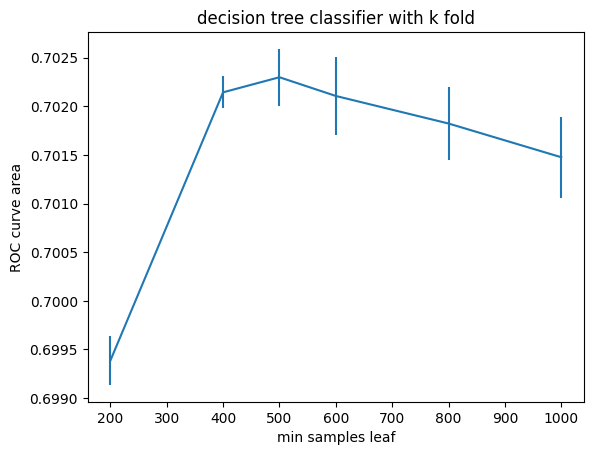

In [11]:
def fineTuneDecisionTree(trainingSet , kFold):
    results = dict() ; avgGrade = dict() ; stdGrade = dict() ; minGrade = dict() ; maxGrade = dict() ; bestSampleLeaf = 0 ; bestGrade = 0.5
    for minVal in [200 , 400, 500 , 600 , 800 , 1000]:
        featureSet = [c for c in trainingSet.columns if c not in ['HasDetections' , 'MachineIdentifier']]
        decisionTree = DecisionTreeClassifier(min_samples_leaf = minVal)
        results[minVal] = []
        for trainIdx , testIdx in kFold.split(trainingSet):
            decisionTree.fit(trainingSet[featureSet].iloc[trainIdx] , trainingSet['HasDetections'].iloc[trainIdx])
            probab = decisionTree.predict_proba(trainingSet[featureSet].iloc[testIdx])
            fVal , tVal , threshold = sklearn.metrics.roc_curve(trainingSet['HasDetections'].iloc[testIdx] , probab[:,1])
            results[minVal].append(sklearn.metrics.auc(fVal , tVal))
        grade = np.mean(results[minVal])
        if grade > bestGrade:
            bestGrade = grade
            bestSampleLeaf = minVal
        avgGrade[minVal] = grade
        stdGrade[minVal] = np.std(results[minVal])
        minGrade[minVal] = np.min(results[minVal])
        maxGrade[minVal] = np.max(results[minVal])  
    nLeafs = avgGrade.keys()
    avgs = [avgGrade[k] for k in nLeafs]
    stds = [stdGrade[k] for k in nLeafs]
    plt.figure()
    plt.errorbar(nLeafs , avgs , stds)
    plt.title('decision tree classifier with k fold')
    plt.xlabel('min samples leaf')
    plt.ylabel('ROC curve area')
    plt.show()
    return DecisionTreeClassifier(min_samples_leaf=bestSampleLeaf)
kFold = KFold(n_splits=5 , shuffle=True)
classifier = fineTuneDecisionTree(trainingSet , kFold)

In [12]:
features = [x for x in trainingSet.columns if x not in ['HasDetections' , 'MachineIdentifier']]
x = trainingSet[features]
y = trainingSet['HasDetections']
del trainingSet

classifier.fit(x , y)

DecisionTreeClassifier(min_samples_leaf=500)

In [18]:
# del x , y -- uncomment when run again
test = pd.read_csv('testdecisiontrees.csv' , dtype=dtypes)
removeNans(test , nanDict)
x = test[features] 
ypred = classifier.predict_proba(x)[:,1]
toSubmit = pd.DataFrame(test['MachineIdentifier'])
toSubmit['HasDetections'] = ypred
toSubmit.to_csv('submission.csv' , index=False)

In [19]:
submit = pd.read_csv('submission.csv')
print(submit.shape)

(7853253, 2)
